# Quickstart tutorial

This tutorial will go through the basic ways to use `floweaver` to process and transform data into many different Sankey diagrams.

>  If you are reading the static documentation, you can also try an interactive version of this tutorial online [using MyBinder](https://mybinder.org/v2/gh/ricklupton/floweaver/master?filepath=docs%2Ftutorials%2Fquickstart.ipynb)

Let's start by making a really simple dataset. Imagine we have some farms, which grow apples and bananas to sell to a few different customers. We can describe the *flow* of fruit from the farms (the *source* of the flow) to the customers (the *target* of the flow):

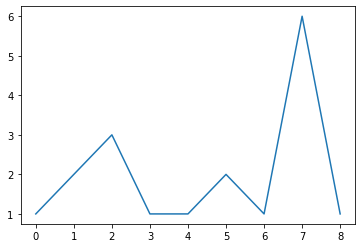

In [25]:
import pandas as pd
flows = pd.read_csv('../../simple_fruit_sales.csv')
flows
import matplotlib.pyplot as plt
import networkx as nx

a = networkx.Graph()
a.add_edge("a", "b")
a.add_edge("a", "c")
a.add_edge("c", "d")
a.add_edge("c", "e")
a.add_edge("e", "b")

#plt.subplot(121)
#nx.draw(a, with_labels=True)

# from networkx.drawing.nx_pydot import write_dot
# G = nx.petersen_graph()
# pos = nx.nx_agraph.graphviz_layout(G)

# nx.draw(G, pos=pos, with_labels=True)

test = [1,2,3,1,1,2,1,6,1]
plt.plot(test)

Drawn directly as a Sankey diagram, this data would look something like this:

In [2]:
from ipysankeywidget import SankeyWidget
SankeyWidget(links=flows.to_dict('records'))

SankeyWidget(links=[{'source': 'farm1', 'target': 'Mary', 'type': 'apples', 'value': 5}, {'source': 'farm1', '…

But you don't always want a direct correspondence between the flows in your data and the links that you see in the Sankey diagram. For example:

* Farms 4, 5 and 6 are all pretty small, and to make the diagram clearer we might want to group them in an "other" category.
* The flows of apples are mixed in with the flows of bananas -- we might want to group the kinds of fruit together to make them easier to compare
* We might want to group farms or customers based on some other attributes -- to see difference between genders, locations, or organic/non-organic farms, say.

This introduction shows how to use `floweaver` to do some of these for this simple example, in the simplest possible way. Later tutorials will show how to use it on real data, and more efficient ways to do the same things.

## Basic diagram

Let's start with the first example: grouping farms 4, 5 and 6 into an "other" category. `floweaver` works by setting up a "Sankey diagram definition" which describes the structure of the diagram we want to see. In this case, we need to set up some groups:

In [3]:
from floweaver import *

# Set the default size to fit the documentation better.
size = dict(width=570, height=300)

nodes = {
    'farms': ProcessGroup(['farm1', 'farm2', 'farm3', 
                           'farm4', 'farm5', 'farm6']),
    'customers': ProcessGroup(['James', 'Mary', 'Fred', 'Susan']),
}

We need to describe roughly how these groups should be placed in the final diagram by defining an "ordering" -- a list of vertical slices, each containing a list of node ids:

In [5]:
ordering = [
    ['farms'],       # put "farms" on the left...
    ['customers'],   # ... and "customers" on the right.
]

And we also need to say which connections should appear in the diagram (sometimes you don't want to actually see all the connections). This is called a "bundle" because it bundles up multiple flows -- in this case all of them.

In [6]:
bundles = [
    Bundle('farms', 'customers'),
]

Putting that together into a Sankey diagram definition (SDD) and applying it to the data gives this result:

In [7]:
sdd = SankeyDefinition(nodes, bundles, ordering)
widget = weave(sdd, flows).to_widget(**size)
widget.auto_save_png("mysankey.png")

SankeyWidget(layout=Layout(height='300', width='570'), links=[{'source': 'farms^*', 'target': 'customers^*', '…

That's not very useful. What's happened? Every farm and every customer has been lumped together into one group. To get the picture we want -- like the first one, but with an "other" group containing farms 4, 5 and 6 -- we need to *partition* the groups:

In [8]:
# The first argument is the dimension name -- for now we're using
# "process" to group by process ids. The second argument is a list
# of groups.
farms_with_other = Partition.Simple('process', [
    'farm1',  # the groups within the partition can be a single id...
    'farm2',
    'farm3',
    ('other', ['farm4', 'farm5', 'farm6']),   # ... or a group
])

# This is another partition.
customers_by_name = Partition.Simple('process', [
    'James', 'Mary', 'Fred', 'Susan'
])

# Update the ProcessGroup nodes to use the partitions
nodes['farms'].partition = farms_with_other
nodes['customers'].partition = customers_by_name

# New Sankey!
widget = weave(sdd, flows).to_widget(**size)
widget.auto_save_png("mysankey.png")

SankeyWidget(groups=[{'id': 'farms', 'type': 'process', 'title': '', 'nodes': ['farms^farm1', 'farms^farm2', '…

That's better: now the farms are split up appropriately with an "other" category, and the customers are shown separately as well. We don't have to stop there -- what about showing sales to men and women?

In [10]:
customers_by_gender = Partition.Simple('process', [
    ('Men', ['Fred', 'James']),
    ('Women', ['Susan', 'Mary']),
])

nodes['customers'].partition = customers_by_gender

weave(sdd, flows).to_widget(**size).auto_save_png('quickstart_example1.png')

SankeyWidget(groups=[{'id': 'farms', 'type': 'process', 'title': '', 'nodes': ['farms^farm1', 'farms^farm2', '…

> There is a better way of specifying this type of partition that doesn't involve hard-coding who's a man and who's a woman into the code -- see the later tutorial on using *dimension tables*.

## Distinguishing flow types

These diagrams have lost sight of the kind of fruit that is actually being sold -- are the men buying apples, bananas or both from farm1? To show this we need to split up the flows in the diagram based on their *type*. Just like we split up the `ProcessGroups` by defining a partition of processes, we split up flows by defining a partition of flows.

(While we're at it let's choose some colours that look vaguely like apples and bananas)

In [11]:
# Another partition -- but this time the dimension is the "type"
# column of the flows table
fruits_by_type = Partition.Simple('type', ['apples', 'bananas'])

# Set the colours for the labels in the partition.
palette = {'apples': 'yellowgreen', 'bananas': 'gold'}

# New SDD with the flow_partition set
sdd = SankeyDefinition(nodes, bundles, ordering, 
                       flow_partition=fruits_by_type)

weave(sdd, flows, palette=palette).to_widget(**size)

SankeyWidget(groups=[{'id': 'farms', 'type': 'process', 'title': '', 'nodes': ['farms^farm1', 'farms^farm2', '…

As a last step, it would be nice to label which flows are apples and which are bananas. One way to do this would be to use a legend next to the diagram, or to put labels on every flow. Here, we'll add a new layer in the middle of the diagram which temporarily groups together the different fruit types on their way from the farms to the customers. This temporary/additional grouping point is called a *waypoint*.

To add a waypoint, we need to do three things:

1. Define it as a node
2. Position it in the ordering (between `farms` and `customers`)
3. Add it to the bundle

In [ ]:
# 1. Define a new waypoint node
nodes['waypoint'] = Waypoint()

# 2. Update the ordering to show where the waypoint goes: in the middle
ordering = [
    ['farms'],
    ['waypoint'],
    ['customers'],
]

# 3. Update the bundle definition to send the flows via the waypoint
bundles = [
    Bundle('farms', 'customers', waypoints=['waypoint']),
]

# Update the SDD with the new nodes, ordering & bundles.
sdd = SankeyDefinition(nodes, bundles, ordering, 
                       flow_partition=fruits_by_type)

weave(sdd, flows, palette=palette).to_widget(**size)

That's not yet very useful. Just like above, the default for Waypoints is to group everything togeter. We need to set a partition on the waypoint to split apart apples and bananas:

In [ ]:
# Redefine the waypoint with a partition (same one defined above)
nodes['waypoint'] = Waypoint(fruits_by_type)

weave(sdd, flows, palette=palette).to_widget(**size)

## Summary

This has demonstrated the basic usage of `floweaver`: defining `ProcessGroup`s, `Waypoint`s, `Partition`s, and `Bundle`s. If you are reading the interactive version, why not go back and try out some different ways to present the data? Here are some suggestions:

1. Farms 1, 3 and 5 are organic. Can you change the farm Partition to show two groups, organic and non-organic?
2. What happens if you remove `"farm1"` from the original definition of the `farms` `ProcessGroup`? (Hint: those apples that James and Mary are eating have to come from somewhere -- so they are shown as coming from "elsewhere". See [later tutorial on moving the system boundary](/tutorials/system-boundary.ipynb))

If you are reading the static documentation, you can easily experiment with editing and rerunning this tutorial online [using MyBinder](https://mybinder.org/v2/gh/ricklupton/floweaver/master?filepath=docs%2Ftutorials%2Fquickstart.ipynb), or download it to run on your computer from [GitHub](https://github.com/ricklupton/floweaver/archive/master.zip).